In [83]:
from matplotlib import pyplot as plt
import numpy as np
import h5py 
import yaml
import datetime
import os
import h5py
from tqdm import tqdm
from sklearn.decomposition import PCA
import json
import time
from scipy.optimize import curve_fit

gain = 4.522 #mV/ke-

filename = 'packet-2024_04_04_07_55_38_PDT.h5'
ofilename = 'simple-2024_04_04_07_55_38_PDT.h5'
odir = '/global/cfs/projectdirs/dune/www/data/Lbl-singlecube/March2024/overnight_04_03/simple/'
datadir = '/global/cfs/projectdirs/dune/www/data/Lbl-singlecube/March2024/overnight_04_03/packet/'
configdir = '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/asic_configs/'
pedestal_filename='/global/cfs/projectdirs/dune/www/data/Lbl-singlecube/March2024/packet-2024_04_03_18_38_39_PDT.h5'
light_event_nhit=3
light_event_timeout=7
charge_event_nhit=3
charge_event_timeout=3000 #clock cycles
light_charge_match_tdiff=5000 #clock cycles
vref_dac=223
vcm_dac=68
max_ts_diff = 3000


def get_list_of_h5_files(file_or_dir_name):
    if os.path.isfile(file_or_dir_name):
        return [file_or_dir_name]
    else:
        base = file_or_dir_name
        sorted_files = [base + "/" + name for name in os.listdir(base) if (name[-3:] == ".h5")]
        sorted_files.sort(key=lambda x: os.path.getmtime(x))
        return sorted_files

nonrouted_channels=[6,7,8,9,22,23,24,25,38,39,40,54,55,56,57]
routed_channels=[i for i in range(64) if i not in nonrouted_channels]

geo=None
geometrypath = 'layout-2.4.0.yaml'
with open(geometrypath) as fi:
    geo=yaml.full_load(fi)

chip_pix=dict([(chip_id, pix) for chip_id,pix in geo['chips']])

N_CHIPS=101
N_CHANNELS=64

all_uniques = np.zeros( N_CHIPS*N_CHANNELS )
pixel_x     = np.zeros( N_CHIPS*N_CHANNELS )
pixel_y     = np.zeros( N_CHIPS*N_CHANNELS )

def chip_channel_to_index(chip, channel):
    return (chip-11)*N_CHANNELS + channel

counter_used = set()

for chip in range(11, 111):
    for channel in range(64):
        pix=chip_pix[chip][channel]
        counter = chip_channel_to_index(chip, channel)
        if not pix is None:
            pixel_x[counter] = geo['pixels'][pix][1]
            pixel_y[counter] = geo['pixels'][pix][2]

#Construct Light Geometry
light_channels = [30, 20, 18, 16, 14, 12, 4, 2, 0, 62, 52, 50, 48, 46, 44, 32]
light_channel_index = np.ones(N_CHANNELS)*-1

for ich, channel in enumerate(light_channels):
    light_channel_index[channel] = ich

#Gives TOP to BOTTOM numbering of channels
light_channel_index = light_channel_index.astype(int)

In [64]:
sync_packet_type = 6
vd = 0.016 #cm/clock cycle

        
def find_events(packets): 
    #get true timestamps accounting for sync
    true_timestamps = packets['timestamp']    
    dmask = np.logical_and(packets['packet_type']==0, packets['valid_parity']==1)
    
    dtime, data = true_timestamps[dmask], packets[dmask]
    
    charge_mask = data['io_channel'] <  5
    light_mask  = data['io_channel'] == 5
    
    ctime, cdata = dtime[charge_mask], data[charge_mask]
    ltime, ldata = dtime[light_mask], data[light_mask]
 
    charge_clusters = (np.ones( len(cdata)  )*-1).astype(int)
    light_clusters =  (np.ones( len(ldata)  )*-1).astype(int)
        
    #cluster light
    
    if True:
        #histogram into 1.2 us bins
        print('clustering light into {} 1.2us bins'.format(int((max(ltime)-min(ltime))//12)))
        values, bins = np.histogram(ltime, range=(min(ltime), max(ltime)), bins=int((max(ltime)-min(ltime))//10) )
        all_event_bin_times = (bins[:-1] + bins[1:])/2
        
        events_mask = values >= light_event_nhit
        
        #find edges in events mask
        event_edge = events_mask[:-1].astype(int) - events_mask[1:].astype(int) 
        
        started_high= events_mask[0]==1 
        add = [0]
        if started_high: add=[1]
        event_edge = np.array( add + list(event_edge)    )
        #  1 if 1-->0
        # -1 if 0-->1
        #  0 if 1->1 or 0--0
        
        #look for -1-->1 transitions (start consecutive bins to end and take average time)
        
        starts = np.argwhere(event_edge==-1)[:,0]-1
        ends   = np.argwhere(event_edge== 1)[:,0]+1
        
        if not starts.size==ends.size:
            if starts.size > ends.size: #ended with nonzero event
                ends = list(ends)
                ends.append(ends[-1]+1)
                ends=np.array(ends)
            if starts.size<ends.size:
                #started with nonzero event
                starts = list(starts)
                starts=[starts[0]-1] + starts
                starts=np.array(starts)
                            
        event_times_start = all_event_bin_times[starts]
        event_times_end = all_event_bin_times[ends]
        light_event_start = event_times_start
        
        evt_time = np.zeros(len(event_times_start)+1)
        
        
        for ievt in tqdm(range(len(event_times_start))):
            td = np.logical_and( ltime <= event_times_end[ievt], ltime >= event_times_start[ievt] ) 
            light_clusters[td] = ievt       
            if np.sum(td)==0: print(ievt)
    #cluster charge events
    
    ievt = len(light_event_start)
    
    if True:        
        #histogram into 10 us bins
        values, bins = np.histogram(ctime, range=(min(ctime), max(ctime)), bins=int((max(ctime)-min(ctime))//100) )
        all_event_bin_times = (bins[:-1] + bins[1:])/2
        
        events_mask = values >= charge_event_nhit
        
        #find edges in events mask
        
        event_edge = events_mask[:-1].astype(int) - events_mask[1:].astype(int) 
        started_high= events_mask[0]==1 
        add = [0]
        if started_high: add=[1]
        event_edge = np.array( add + list(event_edge)    )
        #  1 if 1-->0
        # -1 if 0-->1
        #  0 if 1->1 or 0--0
        
        #look for -1-->1 transitions (start consecutive bins to end and take average time)
        
        starts = np.argwhere(event_edge==-1)[:,0]-1
        ends   = np.argwhere(event_edge== 1)[:,0]+1
        
        if not starts.size==ends.size:
            if starts.size > ends.size: #ended with nonzero event
                ends = list(ends)
                ends.append(ends[-1]+1)
                ends=np.array(ends)
            if starts.size<ends.size:
                #started with nonzero event
                starts = list(starts)
                starts=[starts[0]-1] + starts
                starts=np.array(starts)
                
        event_times_start = all_event_bin_times[starts]
        event_times_end = all_event_bin_times[ends]
        charge_event_start = event_times_start
            
        matched=0
        for cevent in tqdm(range(len(starts))):
            cmask = np.logical_and(ctime >= event_times_start[cevent], ctime <= event_times_end[cevent])
            
            #see if any light triggers in this time
            lmask = np.logical_and(light_event_start >= event_times_start[cevent]-light_charge_match_tdiff,\
                                          light_event_start <= event_times_end[cevent]+light_charge_match_tdiff)
            if np.any(lmask):
                evt = np.max(np.argwhere(lmask))
                charge_clusters[cmask] = evt
                matched+=1
            else:
                charge_clusters[cmask] = ievt
                ievt +=1    
    print('matched {} events'.format(matched))
    return dict( {
        'charge_data'     : cdata,
        'charge_time'     : ctime,
        'light_data'      : ldata,
        'light_time'      : ltime,
        'charge_clusters' : charge_clusters,
        'light_clusters'  : light_clusters,
        'light_event_start': light_event_start,
        'charge_event_start': charge_event_start
    } )

In [55]:
def get_all_channel_mean(unique, data):
    u = np.array(list(set(unique)))
    d = np.zeros(len(u))
    iun=0
    for un in tqdm(u):
        mask = unique==un
        d[iun] = np.mean(data[mask])
        iun+=1
        
    return u, d

def get_all_channel_std(unique, data):
    u = np.array(list(set(unique)))
    d = np.zeros(len(u))
    iun=0
    for un in tqdm(u):
        mask = unique==un
        d[iun] = np.std(data[mask])
        iun+=1
        
    return u, d

def get_all_channel_count(unique, data):
    u = np.array(list(set(unique)))
    d = np.zeros(len(u))
    iun=0
    for un in tqdm(u):
        mask = unique==un
        d[iun] = np.sum(mask.astype(int))
        iun+=1
        
def get_date_datafile(filename):
    dtime = ((filename.split('packets-')[-1]).split('.h5')[0]).split('_')
    year = int(dtime[0])
    month = int(dtime[1])
    day = int(dtime[2])
    hour = int(dtime[3])
    minute = int(dtime[4])
    second = int(dtime[5])
    return year, month, day, hour, minute, second 

def get_date_config(filename):
    dtime = (filename.split('asic_configs_')[-1]).split('_')
    year = int(dtime[0])
    month = int(dtime[1])
    day = int(dtime[2])
    hour = int(dtime[3])
    minute = int(dtime[4])
    second=0
    try:
        second = int(dtime[-1])
    except:
        second = 0
    return year, month, day, hour, minute, second 

In [56]:
def display_1d(c,title=None):
    fig = plt.figure(figsize=(12, 10) )
    ax = fig.add_subplot()
    ax.hist(c, bins=50, range=(0, 100))
    ax.set_xlabel('dataword [adc]', fontsize=12)
    ax.grid()
    if not title is None: ax.set_title(title)
    plt.show()
    
def display_2d(x, y, c, title=None, cut=None):
    fig = plt.figure(figsize=(12, 10) )
    ax = fig.add_subplot()
    mask = [True]*len(c)
    if not cut is None:
        mask = c < cut
    
    sc = ax.scatter(x[mask], y[mask], c=c[mask], marker='s', s=40)
    #ax.axhline(50, color='red')

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('dataword', rotation=270)
    if not title is None: ax.set_title(title)
    plt.show()
    
def display_3d(x, y, z, c, title=None, view=None):
    fig = plt.figure(figsize=(6, 5) )
    ax = fig.add_subplot(projection='3d')
    sc = ax.scatter(x, y, z, c=c, marker='.', s=20, alpha=0.85)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('charge [ke-]', rotation=270, fontsize=14)
    if not view is None:
        ax.view_init(*view)
    
    ax.set_xlabel('x [mm]', fontsize=12)
    ax.set_ylabel('y [mm]', fontsize=12)
    ax.set_zlabel('z (drift) [mm]', fontsize=12)
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    #ax.set_zlim(0, 100)
    #ax.set_zlim(0, 5)
    if not title is None: ax.set_title(title)
    plt.show()
    
def dword_to_mv(dword):
    vref = vref_dac/256*1800.
    vcm  = vcm_dac/256*1800
    return (dword/256.)*(vref-vcm) + vcm

def get_pedestals(filename):
    #Pedestal File
    f = h5py.File(filename)
    packets = f['packets']
    packets['chip_id'][packets['io_channel']==5]=111
    dmask = np.logical_and(packets['packet_type']==0, packets['valid_parity']==1)
    dmask = np.logical_and(dmask, packets['chip_id']<111)
    data = packets[dmask]

    q = data['dataword']
    indices = chip_channel_to_index(data['chip_id'].astype(int), data['channel_id'].astype(int))
    pedu, pedmean = get_all_channel_mean(indices, q)
    peds_ind = np.zeros(101*64)
    for chip in range(11, 112):
        for channel in range(64):
            counter = chip_channel_to_index(chip, channel)
            if counter in pedu:
                peds_ind[counter] = dword_to_mv(pedmean[np.where(pedu==counter)[0][0]])
    return peds_ind

peds_ind = get_pedestals(pedestal_filename)

100%|██████████| 4904/4904 [00:09<00:00, 522.23it/s]


In [7]:
def process_file(overwrite=False):
    if True:
        for ifile in list([filename]):
            fname = odir+ofilename
            print('Creating file:', fname)
            if os.path.exists(fname): 
                print('Output file exists: {}'.format(fname))
                if not overwrite: continue
            
            f= h5py.File( datadir + '/' + filename )
            packets = f['packets']
            packets = packets[packets['valid_parity']==1]
            packets = packets[packets['chip_id']<111]
            packets = packets[packets['chip_id']>10]
            if len(packets) < 10:
                print('Fewer than 10 packets in this file--skipping')
                continue
            evs = find_events(packets)
            hf = h5py.File(fname, 'w')
            hf.create_dataset('light_ts', data=evs['light_time'])
            hf.create_dataset('light_event_start', data=evs['light_event_start'])
            hf.create_dataset('charge_event_start', data=evs['charge_event_start'])
            hf.create_dataset('charge_ts', data=evs['charge_time'])
            hf.create_dataset('charge_event', data=evs['charge_clusters'])
            hf.create_dataset('light_event', data=evs['light_clusters'])
            hf.create_dataset('charge_chipid', data=evs['charge_data']['chip_id'])
            hf.create_dataset('charge_chanid', data=evs['charge_data']['channel_id'])
    
            indices = chip_channel_to_index(evs['charge_data']['chip_id'].astype(int),
                                    evs['charge_data']['channel_id'].astype(int))
    
            hf.create_dataset('charge_q', data= (dword_to_mv(evs['charge_data']['dataword'])-peds_ind[indices])/gain )
            hf.create_dataset('charge_x', data=pixel_x[indices] )
            hf.create_dataset('charge_y', data=pixel_y[indices] )
            hf.create_dataset('light_chanid', data=evs['light_data']['channel_id'])
            hf.create_dataset('light_data', data=evs['light_data']['dataword'])
            hf.close()
    
    return fname

In [12]:
# Do t0 reco
from sklearn.decomposition import PCA
vd = 0.016 #cm/clock cycle
def nt0_reco(fname):
    f = h5py.File(fname)
    cz = -99*np.ones( len(f['charge_ts']) )
    levt =f['light_event'][:]
    cevt =f['charge_event'][:]
    lts = f['light_ts'][:]
    cts = f['charge_ts'][:]
    cx = f['charge_x'][:]
    cy = f['charge_y'][:]
    cq = f['charge_q'][:]
    #tmask = np.array(f['charge_ts'])%1e7 > 1
    for evt in tqdm(set(cevt)):
            if evt in levt: continue
            if evt<0: continue
            cmask = cevt==evt
            if sum(cmask)<20: continue
            pca = PCA(n_components=2)
            X =  np.array( [cx[cmask], cy[cmask]] ).transpose()
            pca.fit( X - np.mean(X, axis=0) )
            mevr = max(pca.explained_variance_ratio_)
            if mevr < 0.8: continue
            extent =  (max(cts[cmask]) - min(cts[cmask]))*vd 
            if extent < 2: continue
            print('extent: {} cm'.format(extent))
            #display_3d(cx[cmask], cy[cmask], 10*(cts[cmask])*vd, cq[cmask] )
            
            n = sum(cmask)
            if n > 0: 
                cz[cmask] = (cts[cmask])*vd 
    return cz, cq

In [24]:
# Do t0 reco
from sklearn.decomposition import PCA
vd = 0.016 #cm/clock cycle
def t0_reco(fname):
    f = h5py.File(fname)
    cz = -99*np.ones( len(f['charge_ts']) )
    levt =f['light_event'][:]
    cevt =f['charge_event'][:]
    lts = f['light_ts'][:]
    cts = f['charge_ts'][:]
    cx = f['charge_x'][:]
    cy = f['charge_y'][:]
    cq = f['charge_q'][:]
    #tmask = np.array(f['charge_ts'])%1e7 > 1
    print(len(set(levt)))
    for evt in tqdm(set(levt)):
            if not evt in cevt: continue
            if evt<0: continue
            lmask = levt==evt
            cmask = cevt==evt
            if sum(cmask)<5: continue
            pca = PCA(n_components=2)
            X =  np.array( [cx[cmask], cy[cmask]] ).transpose()
            pca.fit( X - np.mean(X, axis=0) )
            mevr = max(pca.explained_variance_ratio_)
            if mevr < 0.5: continue
            t0 = np.min(lts[lmask])
            #display_3d(cx[cmask], cy[cmask], 10*(cts[cmask]-t0)*vd, cq[cmask] )
            n = sum(cmask)
            if n > 0: 
                cz[cmask] = (cts[cmask] - t0)*vd 
    return cz, cq

In [84]:
fname = process_file(overwrite=True)

Creating file: /global/cfs/projectdirs/dune/www/data/Lbl-singlecube/March2024/overnight_04_03/simple/simple-2024_04_04_07_55_38_PDT.h5
clustering light into 178925932 1.2us bins


100%|██████████| 1674/1674 [00:00<00:00, 3015.80it/s]


matched 439 events


In [85]:
cz, cq = t0_reco(fname)

3668


100%|██████████| 3668/3668 [00:05<00:00, 682.39it/s] 


In [19]:
fname

'/global/cfs/projectdirs/dune/www/data/Lbl-singlecube/March2024/overnight_04_03/simple/simple2-2024_04_03_21_58_32_PDT.h5'

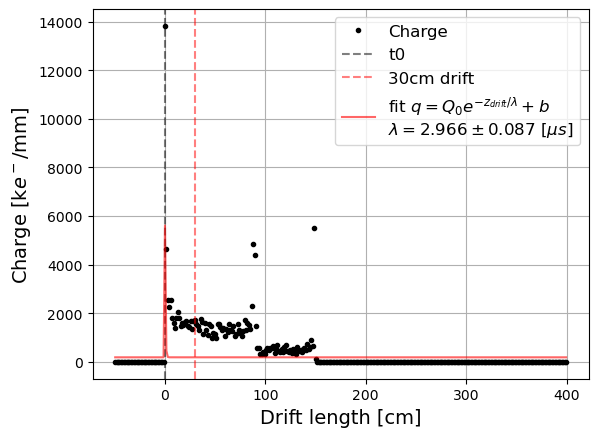

In [87]:
qs, bins = np.histogram(cz, weights=cq, bins=int(51/0.16), range=(-50,400));
dl = (bins[:-1] + bins[1:])/2

fqs, fbins = np.histogram(cz, weights=cq, bins=int( (40-0.321) /0.16), range=(0.321,40));
fdl = (fbins[:-1] + fbins[1:])/2


mm_to_us = 1.6  # mm/us
cm_to_us = 0.16 # cm/us

def exp_plus_offset(x, A, lamb, b):
    gz = x > 0
    ys = np.full(x.shape[0], b).astype(float)
    ys[gz] += A*np.exp( -(x[gz]/lamb) ).astype(float)
    return ys

def exp(x, A, lamb):
    gz = x > 0
    ys = np.full(x.shape[0], 0).astype(float)
    ys[gz] += A*np.exp( -(x[gz]/lamb) ).astype(float)
    return ys

params, pcov = curve_fit(exp_plus_offset, fdl, fqs, p0=[10000, 1, 0])
params_no, pcov_no = curve_fit(exp, fdl, fqs, p0=[10000, 1])

lambda_us = round(params[1]/cm_to_us, 3)
sigma_lambda_us = round(np.sqrt(pcov[1][1])/cm_to_us, 3)

lambda_no_us = round(params_no[1]/cm_to_us, 3)
sigma_lambda_no_us = round(np.sqrt(pcov_no[1][1])/cm_to_us, 3)
            
plot = True
if plot:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.grid(True)
    ax.plot(dl, qs, drawstyle='steps-mid', linestyle='', marker='.', label='Charge', color='black')
    ax.axvline(0-0.05, linestyle='--', color='black', label='t0', alpha=0.5)
    ax.axvline(30+0.05, linestyle='--', color='red', label='30cm drift', alpha=0.5)
    #ax.set_yscale('log')
    ax.set_ylabel('Charge [k$e^-$/mm]', fontsize=14)
    ax.set_xlabel('Drift length [cm]', fontsize=14)
    ax.plot(dl, exp_plus_offset(dl, *params), color='red', alpha=0.6, \
           label=r'fit $q=Q_0e^{-z_{drift}/\lambda}+b$'
            +'\n$\lambda={}\pm${} [$\mu s$]'.format(lambda_us, sigma_lambda_us) \
             #+ '\n$Q_0={}\pm${}'.format( round(params[0], 2), round(np.sqrt(pcov[0][0]), 3) ) \
    #        #+ '\n$b={}\pm${}'.format( round(params[2], 2), round(np.sqrt(pcov[2][2]), 3) )
           )
    
    #ax.plot(dl, exp(dl, *params_no), color='orange', alpha=0.6, \
    #       label=r'fit $q=Q_0e^{-z_{drift}/\lambda}$'
    #        +'\n$\lambda={}\pm${} [$\mu s$]'.format(lambda_no_us, sigma_lambda_no_us) \
    #        #+ '\n$Q_0={}\pm${}'.format( round(params_no[0], 2), round(np.sqrt(pcov_no[0][0]), 3) )
    #       )
    ax.legend(fontsize=12)


In [442]:
f=h5py.File(fname)

In [306]:
diffs=[]
for evt in set(f['light_event']):
    mask = evt==f['light_event']
    time = np.min(f['light_ts'][mask])
    
    d = f['charge_event_start'][:]-time
    diffs.append(np.min(np.absolute(d)) )
    

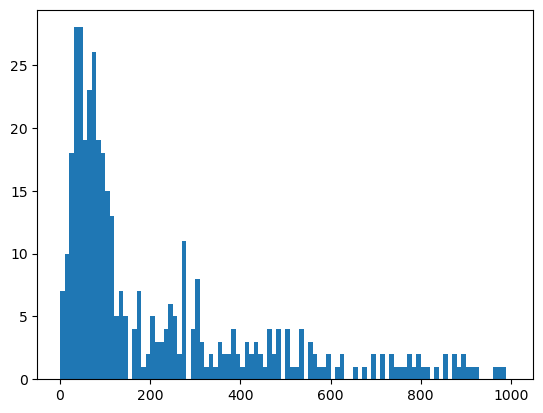

In [307]:
plt.hist(diffs, bins=100, range=(0, 1000));

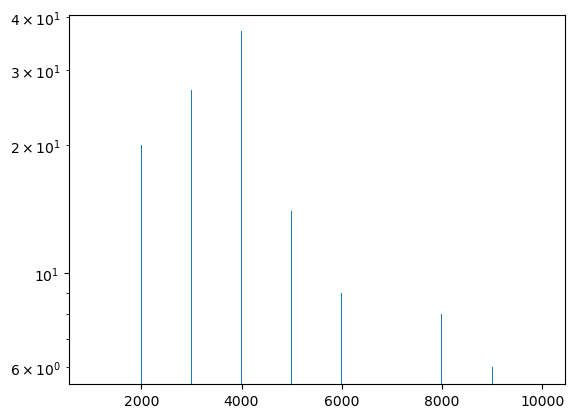

In [445]:
#plt.hist(f['light_event_start'][:], bins=500);
plt.hist(f['charge_event_start'][1:]-f['charge_event_start'][:-1], bins=500, range=(1000,10000));
plt.yscale('log')

In [328]:
len(set(f['light_event']))

4026

In [329]:
len(set(f['light_event_start'])-set(f['charge_event']))

4026

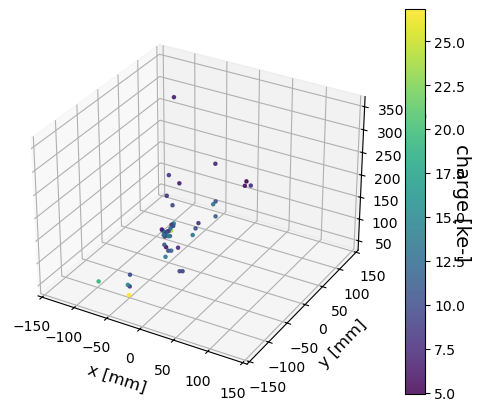

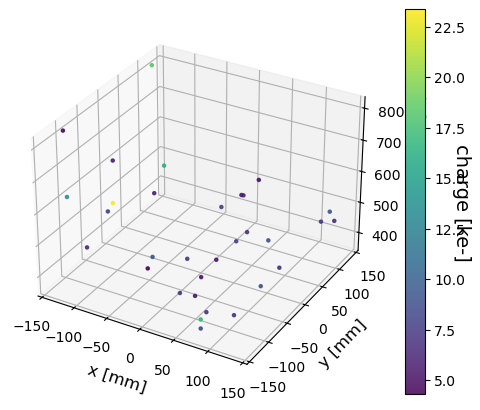

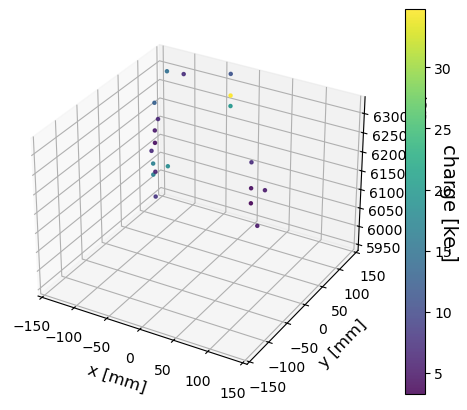

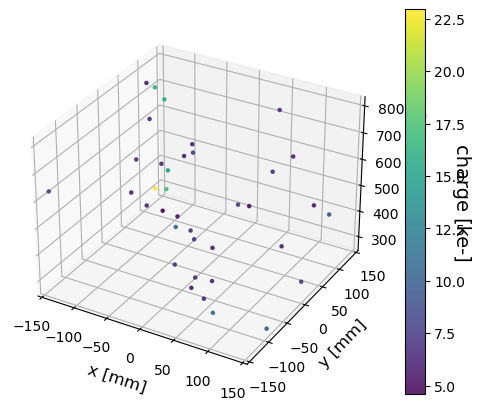

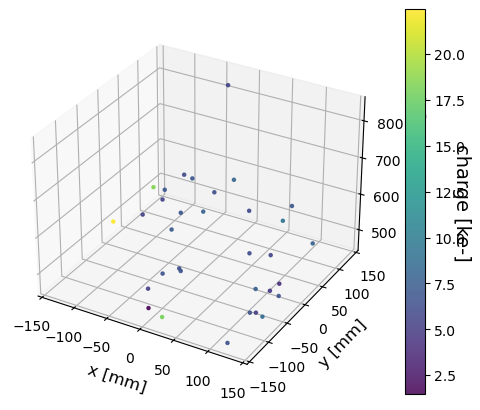

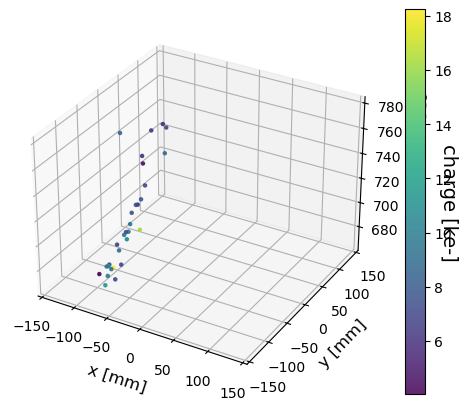

KeyboardInterrupt: 

In [415]:
for evt in set(f['charge_event'][:]):
    mask=f['charge_event']==evt
    if sum(mask) < 20 or sum(mask) > 300: continue
    
    x,y,t,q = f['charge_x'][mask], f['charge_y'][mask], f['charge_ts'][mask], f['charge_q'][mask]
    
    display_3d(x, y, t, q)

In [26]:
f=h5py.File(fname)

In [30]:
len(set(f['light_event']))

280